# Initliziation


## Set Global Variables


In [ ]:
# set system
import sys
IN_COLAB = 'google.colab' in sys.modules
ABDUL_G_DRIVE = True

# set torch device
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Initlize Colab:

### Connect to Drive

In [ ]:
# connect to drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

  # set project path from drive
  if ABDUL_G_DRIVE:
    project_path = "/content/gdrive/MyDrive/00 Projects/AML"
    %cd -q $project_path 
    !pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/00 Projects/AML


### Install PyG in Colab 

In [ ]:
# define dynamic function to install pyg
def install_pyg():
    try:
        import torch_geometric
    except:
        TORCH = torch.__version__.split('+')[0]
        CUDA = 'cu' + torch.version.cuda.replace('.', '')
        !pip install torch-scatter     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-sparse      -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-cluster     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-geometric   -q

# install
if IN_COLAB: install_pyg()

     |████████████████████████████████| 7.9 MB 8.2 MB/s 
     |████████████████████████████████| 3.5 MB 7.8 MB/s 
     |████████████████████████████████| 2.5 MB 7.1 MB/s 
     |████████████████████████████████| 750 kB 9.9 MB/s 
     |████████████████████████████████| 407 kB 7.6 MB/s 


## Load Dependencies

In [ ]:
# src 
from models import MLP, GCN, GAT
from random_split import random_split
from p_reg_loss import A_hat_computations, p_reg_loss
from lap_loss import lap_loss
from cp_loss import cp_loss
from label_smoothing import label_smoothing
from helper import visualize_Atlas, visualize_TSNE, visualize_CM, print_dataset, print_data

# packages
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from sklearn.manifold import TSNE
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import display 
import time

# Train, Test and Evaluation functions

### Train Function

In [ ]:
# Train func
def train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict=None, num_classes = None):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    Z = model(data)     # Perform a single forward pass.    

    if reg_loss == 'ls_reg':
        smooth_label = label_smoothing(data.y[train_mask], num_classes, mu)
        loss_1 = criterion(Z[train_mask], smooth_label)
    else :
        loss_1 = criterion(Z[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
        # to do! 

    if reg_loss == 'p_reg':
        loss_2 = p_reg_loss(Z, 
                        p_reg_dict['A_hat'], 
                        p_reg_dict['A_hat_mask'], 
                        p_reg_dict['N'], 
                        phi = p_reg_dict['phi'])
    elif reg_loss == 'lap_reg': 
        loss_2 = lap_loss(Z, data) 
    elif reg_loss == 'cp_reg': 
        loss_2 = cp_loss(Z)
    elif reg_loss == 'no_reg':
        loss_2 = 0
        assert mu == 0
    
    if reg_loss == 'ls_reg':
        loss = loss_1
    else :
        loss = loss_1 + mu * loss_2

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

## Test Function

In [ ]:
# Test func: Using the early stopping method
def test(model, data, mask, criterion, mu, reg_loss, p_reg_dict=None, num_classes = None, return_metrics = False, return_z = False):
    # eval
    model.eval()
    Z = model(data)

    # cal loss
    if reg_loss == 'ls_reg':
        smooth_label = label_smoothing(data.y[mask], num_classes, mu)
        loss_1 = criterion(Z[mask], smooth_label)
    else :
        loss_1 = criterion(Z[mask], data.y[mask])  # Compute the loss solely based on the training nodes.

    if reg_loss == 'p_reg':
      loss_2 = p_reg_loss(Z, 
                          p_reg_dict['A_hat'], 
                          p_reg_dict['A_hat_mask'],
                          p_reg_dict['N'], 
                          phi = p_reg_dict['phi'])
    elif reg_loss == 'lap_reg': loss_2 = lap_loss(Z, data) 
    elif reg_loss == 'cp_reg': loss_2 = cp_loss(Z)
    elif reg_loss == 'no_reg':
      loss_2 = 0
      assert mu == 0

    if reg_loss == 'ls_reg':
        loss = loss_1
    else :
        loss = loss_1 + mu * loss_2

    # cal metrics
    if return_metrics:
        y_pred = Z.argmax(dim=1)  # Use the class with highest probability.
        score = torch.softmax(Z, dim=1) # tis is for the roc_auc_score
        acc = accuracy_score    (y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy())
        rms = mean_squared_error(y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy(), squared=False)
        roc = roc_auc_score     (y_true = data.y[mask].cpu().detach().numpy(), y_score = score [mask, :].cpu().detach().numpy(), multi_class='ovr')    
        return acc, rms, roc
    elif return_z:
        y_pred = Z.argmax(dim=1)  # Use the class with highest probability.
        acc = accuracy_score    (y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy())
        return acc, Z
    elif return_metrics & return_z:
        y_pred = Z.argmax(dim=1)  # Use the class with highest probability.
        score = torch.softmax(Z, dim=1) # tis is for the roc_auc_score
        acc = accuracy_score    (y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy())
        rms = mean_squared_error(y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy(), squared=False)
        roc = roc_auc_score     (y_true = data.y[mask].cpu().detach().numpy(), y_score = score [mask, :].cpu().detach().numpy(), multi_class='ovr')    
        return acc, rms, roc, Z
    else: 
        y_pred = Z.argmax(dim=1)  # Use the class with highest probability.
        acc = accuracy_score    (y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy())
        return acc

## Evaluation Function

In [ ]:
def evaluation( A = None, # int 
                B = None, # int 
                mu = None, # float 
                seed = None, # float 
                As = None, # int list 
                Bs = None, # int list 
                mus = None, # float list 
                seeds = None, # float list 
                reg_loss = None, # str: 'p_reg', 'lap_reg', 'cp_reg', 'no_reg' 
                p_reg_phi = None, # str: 'cross_entropy', 'squared_error', 'kl_divergence'
                model_name = 'GCN', # str: 'GCN','GAT','MLP'
                datasets = ['Cora', 'CiteSeer', 'PubMed'], # str list
                epochs = 200, # int
                patience = 100, # int 
                verbose = True, # bolean
                return_metrics = False, # for metrics plots
                return_z = False  # for TSNE plot
               ):

    # check A and B arg.
    if (A is not None) | (B is not None):
        assert A is not None, "A is missing" 
        assert B is not None, "B is missing" 
        assert (seed is not None) | (seeds is not None), "seed or seeds is missing"
        assert As is None, "As should not be given"
        assert Bs is None, "Bs should not be given"

    # check mu input arg.
    if mu is not None:
        if mu == 0:
            assert reg_loss == 'no_reg', "reg_loss should be 'no_reg'"

    # check seed input arg.
    if seed is not None: 
        assert seeds is None, "seeds should not be given"
        torch.manual_seed(seed)
        
    # check reg_loss input arg.
    if reg_loss is not None:
        assert reg_loss in ['p_reg', 'lap_reg', 'cp_reg', 'ls_reg', 'no_reg'], "check reg_losse arg."    
        if reg_loss == 'no_reg':
            assert mu == 0, "mu should be 0"
 
    # check p_reg_phi input arg.
    if p_reg_phi is not None:
        assert p_reg_phi in ['cross_entropy', 'squared_error', 'kl_divergence'], 'check p_reg_phi arg.'
        assert reg_loss == 'p_reg' , "reg_loss should be p_reg'"

    # check lists input args
    if mus is not None:
        assert mu is None, "mu should not be given"
        params, params_len, params_tag = mus, len(mus), 'Mus'
        if verbose: print(f'Training with {reg_loss} with different "Mus":')

    elif seeds is not None:
        assert seed is None, "seed should not be given"
        params, params_len, params_tag = seeds, len(seeds), 'Seeds'
        if verbose: print(f'Training with {reg_loss} with different "Seeds":')

    elif (As is not None) | (Bs is not None): 
        assert seed is not None, "seed is missing" 
        assert As is not None, "As are missing"
        assert Bs is not None, "Bs are missing"
        assert len(As) == len (Bs), "As and Bs do not have the same length" 
        assert A is None, "A should not be given"
        assert B is None, "B should not be given"
        params, params_len, params_tag = As, len(As),'Training Nodes'
        if verbose: print(f'Training with {reg_loss} with different "Number Training Nodes":')

    else:
        params, params_len, params_tag = [], 1, 'No Params Loop'
        if verbose: print(f'Training with {reg_loss} with {params_tag}')
        assert (mu is not None) & (reg_loss is not None), 'mu and reg_loss are missing' 

    # evaluation Storage
    Results = {}
    
    # loop over datasets
    for dataset_name in datasets: 
        # define dataset
        if verbose: print(f'=========================\n{dataset_name}:')
        if dataset_name == 'Cora':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
        elif dataset_name == 'CiteSeer':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
        elif dataset_name == 'PubMed':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
            else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())         
        else:
            raise NotImplementedError('Only Cora, CiteSeer and PubMed datasets are supported')
        
        # define data
        data = dataset[0]
        data = data.to(device)

        # calc number of classes if reg_loss == 'ls_reg'
        num_classes = dataset.num_classes

        # calc split here when params_tag == 'Mus' or 'No Params Loop':
        if (params_tag == 'Mus') | (params_tag == 'No Params Loop'):
            if (seed is not None) & (A is not None) & (B is not None):
                train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                train_mask = train_mask.to(device)
                val_mask = val_mask.to(device)
                test_mask = test_mask.to(device)
                assert sum(train_mask)  == num_classes*A
                assert sum(val_mask)  == num_classes*B
            else:
                train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
        
        # calc A_hat as it's training invariant 
        if reg_loss == 'p_reg':
            A_hat, A_hat_mask, N = A_hat_computations(data)
            p_reg_dict = {'A_hat': A_hat, 
                          'A_hat_mask': A_hat_mask, 
                          'N': N, 
                          'phi': 'cross_entropy' if p_reg_phi is None else p_reg_phi}  
        else: 
            p_reg_dict = None

        # define test evaluation metrices
        Results[dataset_name+'_acc' ] = []
        if return_metrics:
            Results[dataset_name+'_rms' ] = []
            Results[dataset_name+'_roc' ] = []
        if return_z:
            Results[dataset_name+'_Z'   ] = []
            Results[dataset_name+'_test_mask'] = []

        # loop over params
        for i in range(params_len):
            # define model parameters        
            if params_tag == 'Mus': 
                mu = mus[i]
            elif params_tag == 'Seeds': 
                seed = seeds[i]
                torch.manual_seed(seed)
                # calc the split
                if (A is not None) & (B is not None):
                    train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                    train_mask = train_mask.to(device)
                    val_mask = val_mask.to(device)
                    test_mask = test_mask.to(device)
                    assert sum(train_mask)  == num_classes*A
                    assert sum(val_mask)  == num_classes*B
                else:
                    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
            elif params_tag == 'Training Nodes': 
                A, B = As[i], Bs[i]
                # calc the split
                if seed is not None:
                    train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                    train_mask = train_mask.to(device)
                    val_mask = val_mask.to(device)
                    test_mask = test_mask.to(device)
                    assert sum(train_mask)  == num_classes*A
                    assert sum(val_mask)  == num_classes*B
                else:
                    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

            # define MOC
            if model_name == 'GCN':
                model = GCN(dataset, hidden_channels=64, seed = 0 if seed is None else seed).to(device) # 16 , 64 
            elif model_name == 'GAT':
                model = GAT(dataset, hidden_channels=16, seed = 0 if seed is None else seed).to(device) # 8 , 16
            elif model_name == 'MLP':
                model = MLP(dataset, hidden_channels=64, seed = 0 if seed is None else seed).to(device) # 16 , 64       
            else: 
                raise NotImplementedError('Only GCA, GAT and MLP models are supported')
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()


            Val_Acc, Train_Loss, Epoch, Break_Epoch  = -np.inf, -np.inf, -1, -1
            for epoch in range(epochs):
                # train
                train_loss = train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict, num_classes)   
                # test
                with torch.no_grad():
                    val_acc = test(model, data, val_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)

                    if val_acc > Val_Acc:
                        if return_metrics: # metrics plot
                            Test_Acc, Test_RMS, Test_ROC = test(model, data, test_mask, criterion, mu, reg_loss, 
                                                                p_reg_dict, num_classes, return_metrics = return_metrics)
                        elif return_z: # TSNE plot
                            Test_Acc, Test_Z = test(model, data, test_mask, criterion, mu, reg_loss, 
                                                    p_reg_dict, num_classes, return_z = return_z)
                        elif return_metrics & return_z: # metrics + TSNE plots 
                            Test_Acc, Test_RMS, Test_ROC, Test_Z = test(model, data, test_mask, criterion, mu, reg_loss, 
                                                                        p_reg_dict, num_classes, return_metrics = return_metrics)
                        else: # default
                            Test_Acc = test(model, data, test_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)
                        
                        Epoch, Train_Loss, Val_Acc = epoch, train_loss , val_acc
                        wait = 0
                    else:
                        wait += 1
                    
                    if wait > patience: 
                        Break_Epoch = epoch
                        break 

            # save test metrices      
            Results[dataset_name+'_acc' ].append(Test_Acc)
            if return_metrics:
                Results[dataset_name+'_rms' ].append(Test_RMS)
                Results[dataset_name+'_roc' ].append(Test_ROC)
            if return_z:
                Results[dataset_name+'_Z'   ].append(Test_Z)
                Results[dataset_name+'_test_mask'].append(test_mask)

            # Print 
            condition = ((verbose) & (i % 2 == 0)) if (params_len < 10) else ((verbose) & (i % 5 == 0))
            precent = int(i/params_len*100)
            if condition:
                Break_Epoch = epochs if Break_Epoch == -1 else Break_Epoch
                if params_tag == 'Training Nodes': 
                    print(f'{precent}%: A,B= ({A},{B}), train_loss: {Train_Loss:.4f}, best_epoch: {Epoch}, break_epoch: {Break_Epoch}')
                elif params_tag == 'Seeds': 
                    print(f'{precent}%: seed= {seed}, train_loss: {Train_Loss:.4f}, best_epoch: {Epoch}, break_epoch: {Break_Epoch}')
                elif params_tag == 'Mus': 
                    print(f'{precent}%: mu= {mu:.4f}, train_loss: {Train_Loss:.4f}, best_epoch: {Epoch}, break_epoch: {Break_Epoch}')
                print(f'    Test_acc: {Test_Acc:.4f}')

    return Results, params, params_tag, reg_loss

# Auxiliary Functions

## Viziual Report Function

In [ ]:
# viz report:  metrices vs params for the 3 datasets on test
def report_vis(Results, params, params_tag, reg_loss, 
               datasets  = ['Cora', 'CiteSeer', 'PubMed'],
               return_metrics = False):
    
    # Auxiliary function for ordring list w.r.t another list
    def aux_sort(lst,params):
          return [i for _,i in sorted(zip(params,lst))]

    # Set figure params
    colors = ['green', 'blue', 'red'][0:len(datasets)]
    if return_metrics: 
        tags = ['acc', 'rms', 'roc']
        titles = ['Accuracy', 'RMS', 'ROC-AUC']
    else:
        tags = ['acc']
        titles = ['Accuracy']

    fig, axs = plt.subplots(1, len(tags), figsize=(20, 6) if len(tags) > 1 else (10, 6))
    if type(axs) != np.ndarray: axs = [axs]
    plt.suptitle(f"{params_tag.capitalize()} Vs. Evaluation Metrics",fontsize=18)
    for i_tag, tag in enumerate(tags):    
        for i_data, dataset_name in enumerate(datasets):
          axs[i_tag].plot(sorted(params),aux_sort(Results[f'{dataset_name}_{tag}'],params), color=colors[i_data], marker='o', label=f'{dataset_name}')
          axs[i_tag].legend()
          axs[i_tag].set_title(f'{titles[i_tag]}')
          axs[i_tag].set_xlabel(params_tag)
          axs[i_tag].set_xticks(sorted(params))
          axs[i_tag].set_xticklabels(sorted(np.round(params,2) if (type(params)==np.ndarray) else params), rotation='vertical')
          axs[i_tag].set_ylabel(f'{tags[i_tag]}')
          axs[i_tag].grid(True)

    caption =   f"The figure shows: {params_tag.capitalize()} " +\
                f"Vs. "+\
                f"Accuracy, RMS and ROC-AUC.\n" if return_metrics else f"Accuracy.\n" +\
                f"The model is evaluated with "+ reg_loss +" on test data." 

    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

## Stats Report Function

In [ ]:
# stats report: best params for the 3 datasets on test
def report_stats(Results, params, params_tag,
                datasets  = ['Cora', 'CiteSeer', 'PubMed'],
                return_metrics = False
                ):
    # Set stats params
    if return_metrics: 
        tags = ['acc', 'rms', 'roc']
        titles = ['Accuracy', 'RMS', 'ROC-AUC']
    else:
        tags = ['acc']
        titles = ['Accuracy']

    for dataset_name in datasets:
        print(f'========= {dataset_name}:')
        for tag in tags:
            if tag != 'rms':
                best = params[np.argmax(Results[f'{dataset_name}_{tag}'])]
                best = np.round(best, 3) if ((type(best) == np.float64) or (type(best) == float)) else best
                print(f"    {tag} best {params_tag} on test: {best}")
            else:
                best = params[np.argmin(Results[f'{dataset_name}_{tag}'])]
                best = np.round(best, 3) if ((type(best) == np.float64) or (type(best) == float)) else best
                print(f"    {tag} best {params_tag} on test: {best}")

## Load Dataset

In [ ]:
def load_dataset(dataset_name):
    # define dataset
    if dataset_name == 'Cora':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
        else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
    elif dataset_name == 'CiteSeer':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
        else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
    elif dataset_name == 'PubMed':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
        else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures()) 
    else:
        raise NotImplementedError('Only Cora, CiteSeer and PubMed datasets are supported')
    return dataset

# Analysis 00 (Simple run)

## Minimum case runs

In [ ]:
Results, params, params_tag, reg_loss = evaluation(mu=0, reg_loss='no_reg')

Training with no_reg with No Params Loop
Cora:
    Test_acc: 0.8210
CiteSeer:
    Test_acc: 0.7170
PubMed:
    Test_acc: 0.7850


In [ ]:
Results, params, params_tag, reg_loss = evaluation(mu=0.5, reg_loss='p_reg', p_reg_phi = 'cross_entropy')

Training with p_reg with No Params Loop
Cora:
    Test_acc: 0.8240
CiteSeer:
    Test_acc: 0.7450
PubMed:
    Test_acc: 0.7850


# Aanalysis 01 (Without P-Reg)

## Fixed A and B with different Seeds

In [ ]:
# set parameters
reg_loss = 'no_reg'
mu = 0
A, B = 20, 30
seeds    = np.arange(10)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, mu= mu, seeds = seeds, reg_loss = reg_loss, return_metrics = True)

Training with no_reg with different "Seeds":
Cora:
0%: seed= 0, train_loss: 0.2080, best_epoch: 127, break_epoch: 200
    Test_acc: 0.8066
50%: seed= 5, train_loss: 0.1793, best_epoch: 159, break_epoch: 200
    Test_acc: 0.8142
CiteSeer:
0%: seed= 0, train_loss: 0.6003, best_epoch: 61, break_epoch: 162
    Test_acc: 0.6888
50%: seed= 5, train_loss: 0.4858, best_epoch: 71, break_epoch: 172
    Test_acc: 0.7040
PubMed:
0%: seed= 0, train_loss: 0.2099, best_epoch: 58, break_epoch: 159
    Test_acc: 0.7803
50%: seed= 5, train_loss: 0.1842, best_epoch: 65, break_epoch: 166
    Test_acc: 0.7911


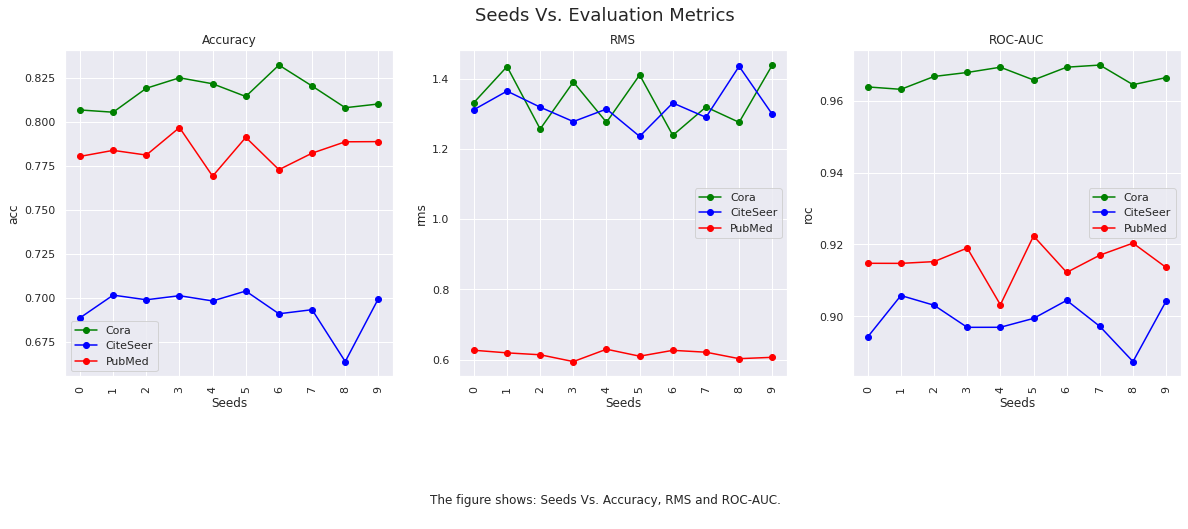

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss, return_metrics = True)

In [ ]:
# report stats
report_stats(Results, params, params_tag, return_metrics = True)

========= Cora:
    acc best Seeds on test: 6
    rms best Seeds on test: 6
    roc best Seeds on test: 7
========= CiteSeer:
    acc best Seeds on test: 5
    rms best Seeds on test: 5
    roc best Seeds on test: 1
========= PubMed:
    acc best Seeds on test: 3
    rms best Seeds on test: 3
    roc best Seeds on test: 5


## Fixed seed with different As and Bs


In [ ]:
# set parameters
reg_loss = 'no_reg'
mu = 0
seed = 3
As = [20, 30, 40, 50, 60] 
Bs = np.array(As) + 10

In [ ]:
# train an evaluate
Results, params, params_tag, reg_loss = evaluation(As = As, Bs = Bs, mu = mu, seed = seed, reg_loss = reg_loss, return_metrics = True)

Training with no_reg with different "Number Training Nodes":
Cora:
0%: A,B= (20,30), train_loss: 0.5618, best_epoch: 47, break_epoch: 148
    Test_acc: 0.8249
40%: A,B= (40,50), train_loss: 0.3310, best_epoch: 107, break_epoch: 200
    Test_acc: 0.8388
80%: A,B= (60,70), train_loss: 0.4490, best_epoch: 85, break_epoch: 186
    Test_acc: 0.8476
CiteSeer:
0%: A,B= (20,30), train_loss: 0.2082, best_epoch: 189, break_epoch: 200
    Test_acc: 0.7014
40%: A,B= (40,50), train_loss: 0.6606, best_epoch: 67, break_epoch: 168
    Test_acc: 0.7173
80%: A,B= (60,70), train_loss: 0.9055, best_epoch: 52, break_epoch: 153
    Test_acc: 0.7244
PubMed:
0%: A,B= (20,30), train_loss: 0.1931, best_epoch: 62, break_epoch: 163
    Test_acc: 0.7966
40%: A,B= (40,50), train_loss: 0.1820, best_epoch: 99, break_epoch: 200
    Test_acc: 0.8143
80%: A,B= (60,70), train_loss: 0.2052, best_epoch: 106, break_epoch: 200
    Test_acc: 0.8046


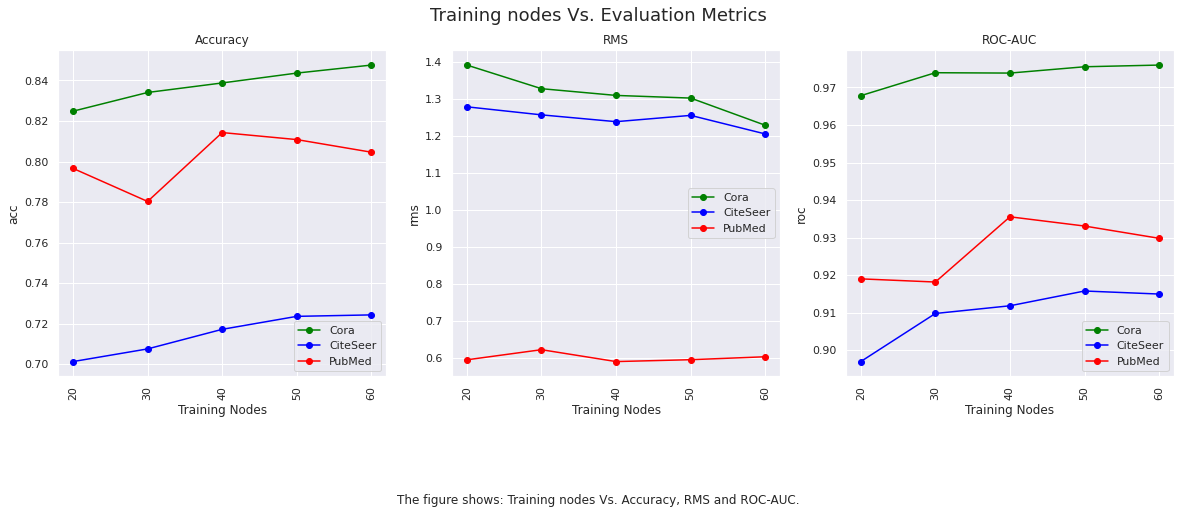

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss, return_metrics = True)

In [ ]:
# report stats
report_stats(Results, params, params_tag, return_metrics = True)

========= Cora:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 60
========= CiteSeer:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 50
========= PubMed:
    acc best Training Nodes on test: 40
    rms best Training Nodes on test: 40
    roc best Training Nodes on test: 40


# Analysis 02 (With P-Reg)

## Original split different Mus


In [ ]:
# set parameters
reg_loss='p_reg'
p_reg_phi = 'cross_entropy'
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(mus=mus, reg_loss=reg_loss, p_reg_phi = p_reg_phi, return_metrics = True)

Training with p_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.6252, best_epoch: 39, break_epoch: 140
    Test_acc: 0.8210
23%: mu= 0.2500, train_loss: 1.1519, best_epoch: 34, break_epoch: 135
    Test_acc: 0.8250
47%: mu= 0.5000, train_loss: 1.4842, best_epoch: 36, break_epoch: 137
    Test_acc: 0.8240
71%: mu= 0.7500, train_loss: 0.5227, best_epoch: 199, break_epoch: 200
    Test_acc: 0.8380
95%: mu= 1.0000, train_loss: 0.6508, best_epoch: 160, break_epoch: 200
    Test_acc: 0.8330
CiteSeer:
0%: mu= 0.0000, train_loss: 0.2369, best_epoch: 196, break_epoch: 200
    Test_acc: 0.7170
23%: mu= 0.2500, train_loss: 0.4835, best_epoch: 166, break_epoch: 200
    Test_acc: 0.7430
47%: mu= 0.5000, train_loss: 0.5653, best_epoch: 186, break_epoch: 200
    Test_acc: 0.7450
71%: mu= 0.7500, train_loss: 0.7715, best_epoch: 138, break_epoch: 200
    Test_acc: 0.7530
95%: mu= 1.0000, train_loss: 3.1231, best_epoch: 21, break_epoch: 122
    Test_acc: 0.6370
PubMed:
0%: mu= 0.0000, trai

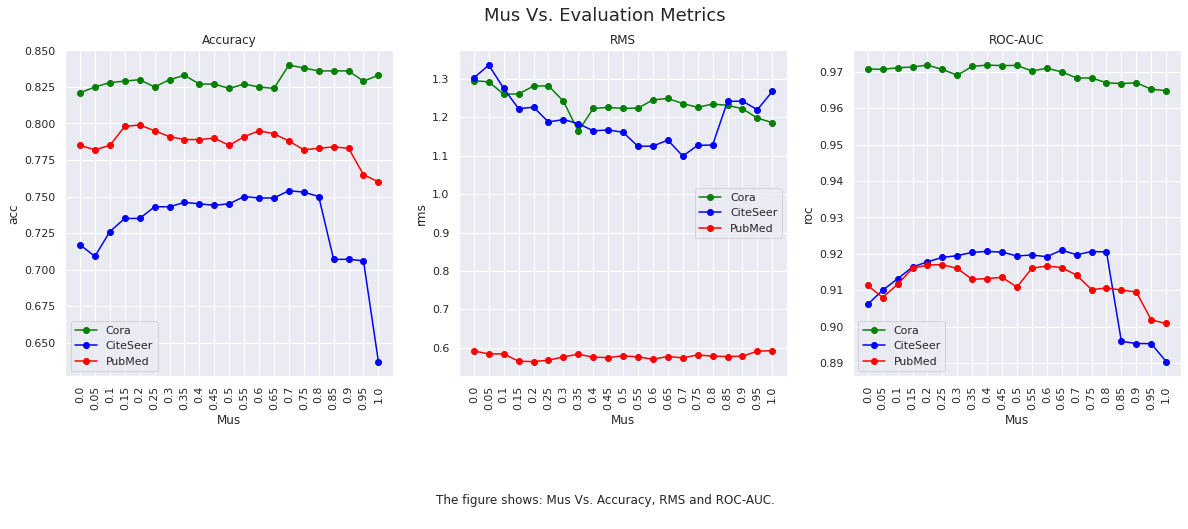

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss, return_metrics = True)

In [ ]:
# report stats
report_stats(Results, params, params_tag, return_metrics = True)

========= Cora:
    acc best Mus on test: 0.7
    rms best Mus on test: 0.35
    roc best Mus on test: 0.2
========= CiteSeer:
    acc best Mus on test: 0.7
    rms best Mus on test: 0.7
    roc best Mus on test: 0.65
========= PubMed:
    acc best Mus on test: 0.2
    rms best Mus on test: 0.2
    roc best Mus on test: 0.25


## Fixed A, B and Mu with different Seeds

In [ ]:
# set parameters
reg_loss = 'p_reg'
A, B = 20, 30
mu       = 0.5
seeds    = np.arange(10)


In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seeds = seeds, mu=mu, reg_loss=reg_loss, return_metrics = True)

Training with p_reg with different "Seeds":
Cora:
0%: seed= 0, train_loss: 0.4564, best_epoch: 177, break_epoch: 200
    Test_acc: 0.7960
50%: seed= 5, train_loss: 0.4973, best_epoch: 154, break_epoch: 200
    Test_acc: 0.8117
CiteSeer:
0%: seed= 0, train_loss: 0.6240, best_epoch: 159, break_epoch: 200
    Test_acc: 0.7103
50%: seed= 5, train_loss: 0.8950, best_epoch: 91, break_epoch: 192
    Test_acc: 0.7040
PubMed:
0%: seed= 0, train_loss: 0.7260, best_epoch: 45, break_epoch: 146
    Test_acc: 0.7778
50%: seed= 5, train_loss: 0.4786, best_epoch: 91, break_epoch: 192
    Test_acc: 0.7684


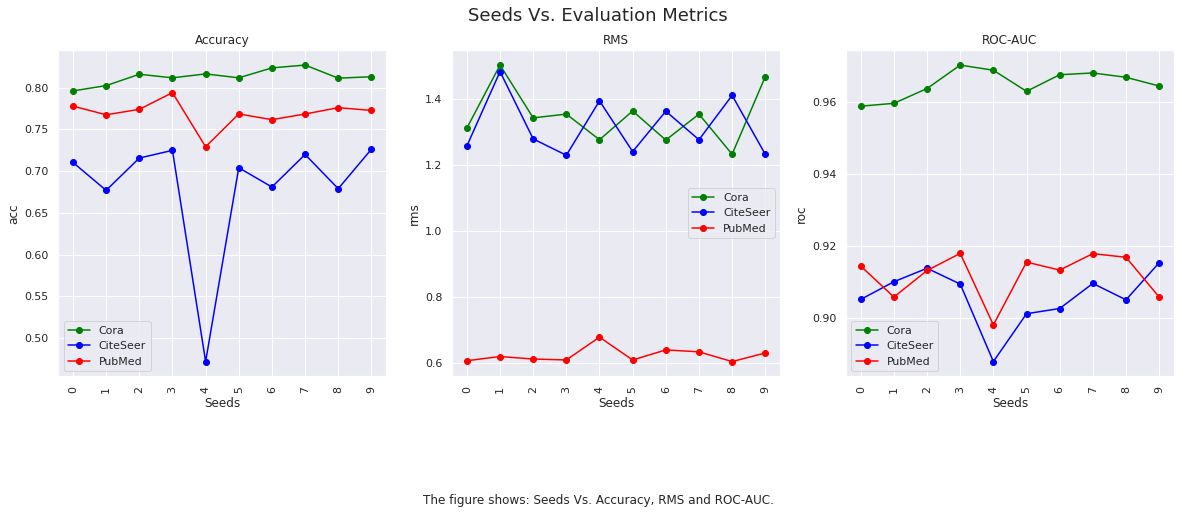

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss, return_metrics = True)

In [ ]:
# report stats
report_stats(Results, params, params_tag, return_metrics = True)

========= Cora:
    acc best Seeds on test: 7
    rms best Seeds on test: 8
    roc best Seeds on test: 3
========= CiteSeer:
    acc best Seeds on test: 9
    rms best Seeds on test: 3
    roc best Seeds on test: 9
========= PubMed:
    acc best Seeds on test: 3
    rms best Seeds on test: 8
    roc best Seeds on test: 3


## Fixed Seed and Mu with different As and Bs

In [ ]:
# set parameters
reg_loss = 'p_reg'
seed = 3
mu = 0.5
As = [20, 30, 40, 50, 60] 
Bs = np.array(As) + 10

In [ ]:
# train an evaluate
Results, params, params_tag, reg_loss = evaluation(As = As, Bs = Bs, mu=mu, seed = seed, reg_loss = reg_loss, return_metrics = True)

Training with p_reg with different "Number Training Nodes":
Cora:
0%: A,B= (20,30), train_loss: 0.9942, best_epoch: 58, break_epoch: 159
    Test_acc: 0.8117
40%: A,B= (40,50), train_loss: 0.5075, best_epoch: 190, break_epoch: 200
    Test_acc: 0.8513
80%: A,B= (60,70), train_loss: 0.6020, best_epoch: 163, break_epoch: 200
    Test_acc: 0.8426
CiteSeer:
0%: A,B= (20,30), train_loss: 0.5822, best_epoch: 147, break_epoch: 200
    Test_acc: 0.7248
40%: A,B= (40,50), train_loss: 0.7454, best_epoch: 144, break_epoch: 200
    Test_acc: 0.7266
80%: A,B= (60,70), train_loss: 0.6566, best_epoch: 196, break_epoch: 200
    Test_acc: 0.7358
PubMed:
0%: A,B= (20,30), train_loss: 0.3402, best_epoch: 199, break_epoch: 200
    Test_acc: 0.7939
40%: A,B= (40,50), train_loss: 0.5030, best_epoch: 99, break_epoch: 200
    Test_acc: 0.8149
80%: A,B= (60,70), train_loss: 0.4418, best_epoch: 145, break_epoch: 200
    Test_acc: 0.8141


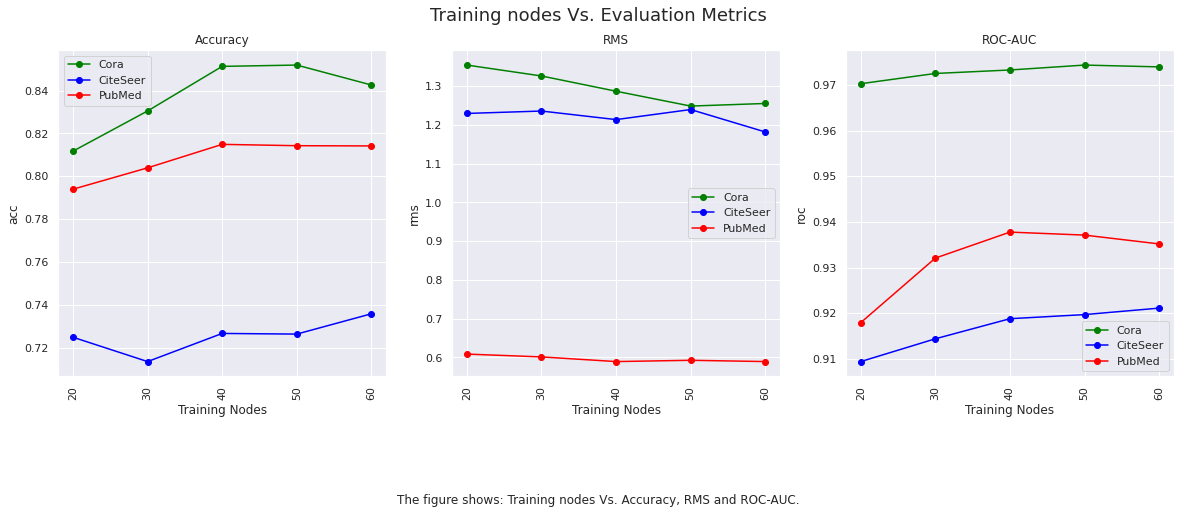

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss, return_metrics = True)

In [ ]:
# report stats
report_stats(Results, params, params_tag, return_metrics = True)

========= Cora:
    acc best Training Nodes on test: 50
    rms best Training Nodes on test: 50
    roc best Training Nodes on test: 50
========= CiteSeer:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 60
========= PubMed:
    acc best Training Nodes on test: 40
    rms best Training Nodes on test: 40
    roc best Training Nodes on test: 40


# Figure 03

## TSNE Functions

In [ ]:
def TSNE_Runs(dataset_Name, reg_mu = 0.5, seed = 0):
    # init storages  
    Results_lst = []
    subtitles = []

    # init 1st run
    """ set sub_title """
    subtitles.append("GCN")

    """ evaluate """ 
    Results, _ , _ , _ = evaluation(
                                datasets = [dataset_Name], 
                                mu = 0, 
                                seed = seed, 
                                reg_loss = 'no_reg',
                                return_z = True,
                                verbose = False
                            )
    Results_lst.append(Results)


    # init 2nd run
    """ set sub_title """
    subtitles.append(f"GCN + P-reg (µ = {reg_mu})")

    """ evaluate """ 
    Results, _ , _ , _ = evaluation(datasets = [dataset_Name], 
                                mu = reg_mu, 
                                seed = seed, 
                                reg_loss = 'p_reg', 
                                p_reg_phi = 'cross_entropy',
                                return_z = True,
                                verbose = False 
                            )
    Results_lst.append(Results)

    # init 3rd run 
    """ set sub_title """
    subtitles.append(f"GCN + Laplacian-reg (µ = {reg_mu})")

    """ evaluate """
    Results, _ , _ , _ = evaluation(datasets = [dataset_Name], 
                                mu = reg_mu, 
                                seed = seed, 
                                reg_loss = 'lap_reg', 
                                return_z = True,
                                verbose = False 
                            )
    Results_lst.append(Results)

    return Results_lst, subtitles, dataset_Name

In [ ]:
# TSNE_Report Function to plot figure 03 from the paper
def TSNE_Report(Results_lst, subtitles, dataset_Name):    
    # check input 
    assert len(Results_lst) == 3, "Results_lst should have 3 values"
    assert len(subtitles) == 3, "subtitles should have 3 values"
    assert dataset_Name in ['Cora', 'CiteSeer', 'PubMed'], "check dataset_Name"

    # from list to dict
    Results_lst = [Results_lst[x] for x in range(len(Results_lst))]
    
    # load dataset
    dataset = load_dataset(dataset_Name)

    # Set figure params
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"{dataset_Name} - TSNE visualization of embeddings on Test data", fontsize=18);
    for i, Results in enumerate(Results_lst): 
        # get Z, test_mask 
        Z = Results[f'{dataset_Name}_Z'][0]
        test_mask = Results[f'{dataset_Name}_test_mask'][0]

        # TSNE Embedding
        transform = TSNE  # or PCA
        trans = transform(n_components=2, init='pca', learning_rate='auto') # random_state=0
        X_reduced = trans.fit_transform(Z[test_mask,:].detach().cpu().numpy())

        # Plot
        axs[i].scatter(
            X_reduced[:, 0],
            X_reduced[:, 1],
            c = dataset[0].y[test_mask],
            cmap = "jet",
            alpha = 0.7,
        )
        axs[i].set(
            xlabel = "$X_1$",
            ylabel = "$X_2$",
            title = subtitles[i]
        )
        
    caption =   f"The t-SNE visualization of GCN outputs " \
                f"on the {dataset_Name} test dataset (best viewed in color)." 
    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

#### CiteSeer

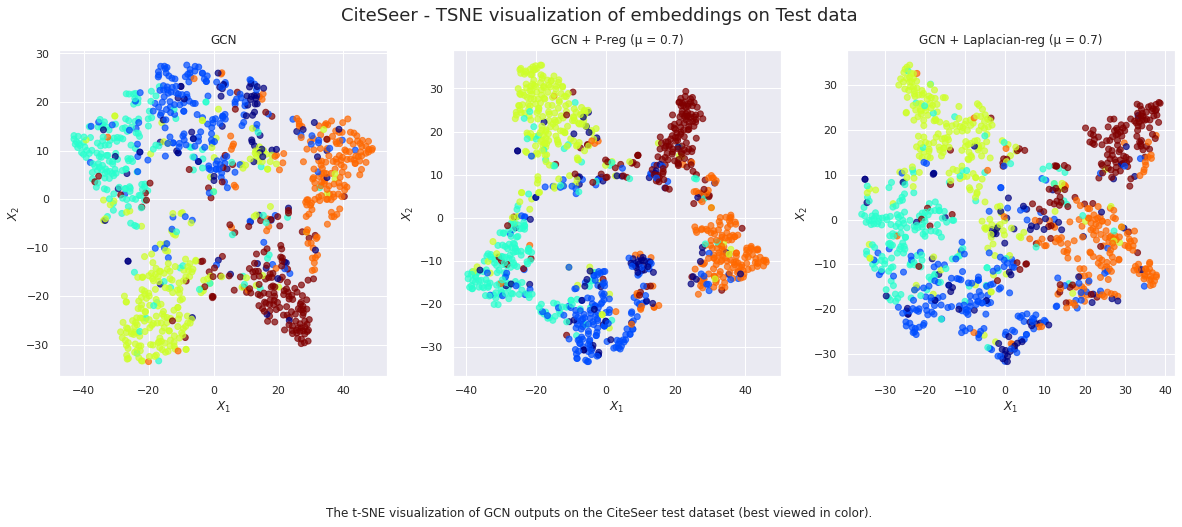

In [ ]:
TSNE_Report(*TSNE_Runs('CiteSeer', reg_mu = 0.7, seed = 9)) # for reg_mu and seed values see Analysis 02  

#### Cora

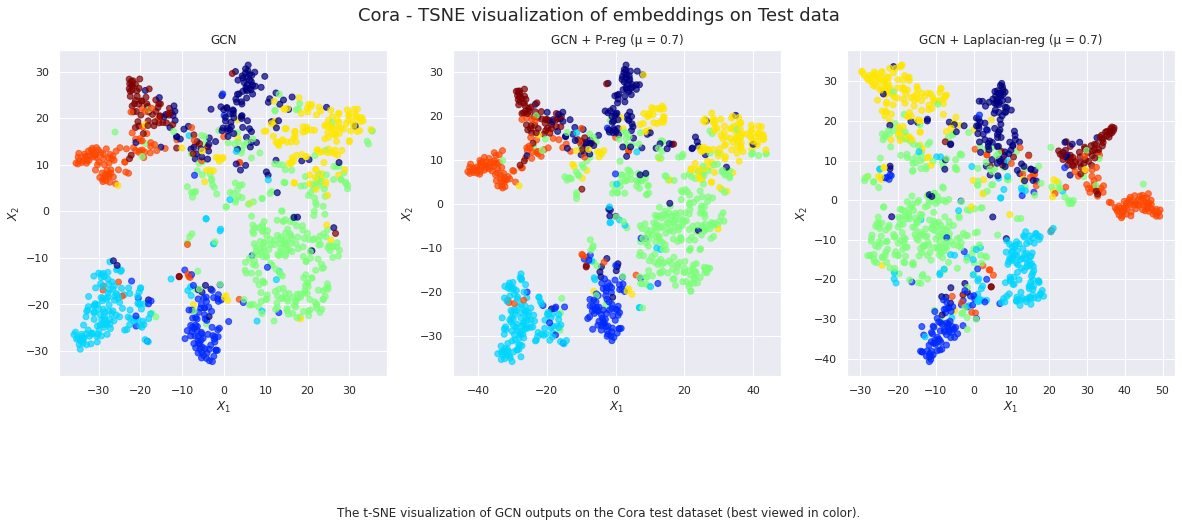

In [ ]:
TSNE_Report(*TSNE_Runs('Cora', reg_mu = 0.7, seed=7)) # for reg_mu and seed values see Analysis 02 

#### PubMed

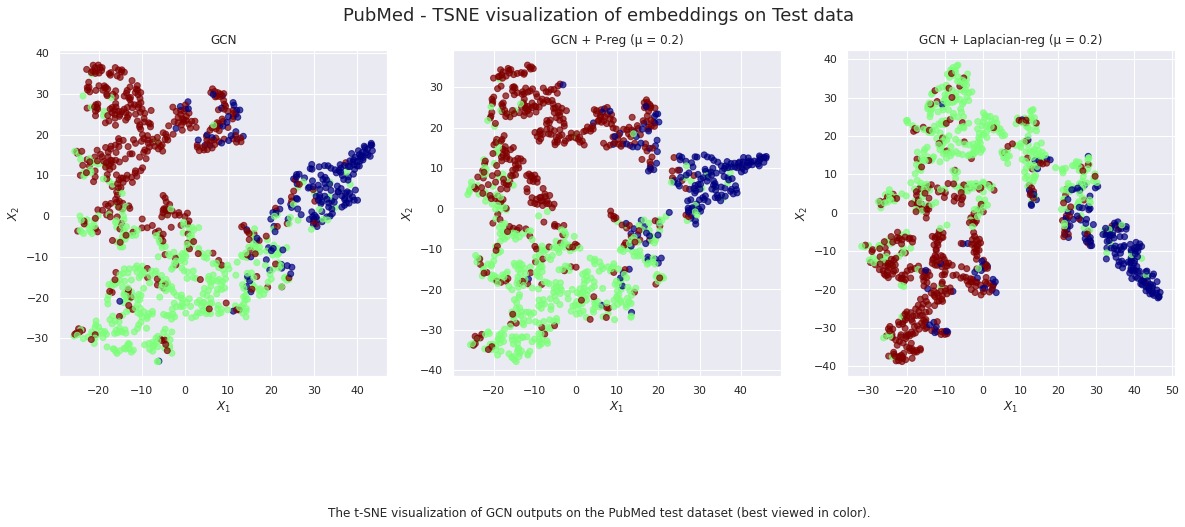

In [ ]:
TSNE_Report(*TSNE_Runs('PubMed', reg_mu = 0.2, seed = 3)) # for reg_mu and seed values see Analysis 02 

# Grid search (Table 01 - Parameters)


## GCN

#### P-Reg
Fixed A, B and Seed with different Mus

In [ ]:
# set parameters
model_name = 'GCN'
reg_loss ='p_reg'
p_reg_phi = 'cross_entropy'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21) 

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss, p_reg_phi = p_reg_phi
                                                   )

Training with p_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.1781, best_epoch: 156, break_epoch: 200
    Test_acc: 0.8041
23%: mu= 0.2500, train_loss: 0.5148, best_epoch: 87, break_epoch: 188
    Test_acc: 0.8024
47%: mu= 0.5000, train_loss: 0.5464, best_epoch: 129, break_epoch: 200
    Test_acc: 0.7998
71%: mu= 0.7500, train_loss: 0.5321, best_epoch: 182, break_epoch: 200
    Test_acc: 0.7935
95%: mu= 1.0000, train_loss: 0.6327, best_epoch: 188, break_epoch: 200
    Test_acc: 0.7078
CiteSeer:
0%: mu= 0.0000, train_loss: 0.6122, best_epoch: 56, break_epoch: 157
    Test_acc: 0.6878
23%: mu= 0.2500, train_loss: 0.8148, best_epoch: 73, break_epoch: 174
    Test_acc: 0.6888
47%: mu= 0.5000, train_loss: 0.8985, best_epoch: 97, break_epoch: 198
    Test_acc: 0.6961
71%: mu= 0.7500, train_loss: 0.6951, best_epoch: 160, break_epoch: 200
    Test_acc: 0.3132
95%: mu= 1.0000, train_loss: 0.8292, best_epoch: 152, break_epoch: 200
    Test_acc: 0.2702
PubMed:
0%: mu= 0.0000, trai

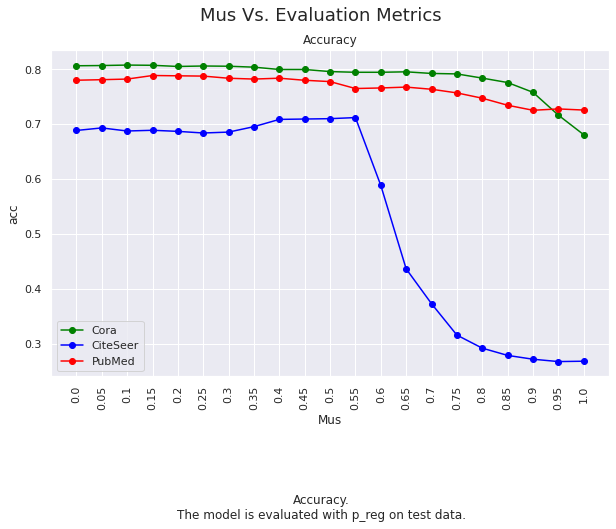

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.1
========= CiteSeer:
    acc best Mus on test: 0.55
========= PubMed:
    acc best Mus on test: 0.15


#### Lap-Reg
Fixed A, B and Seed with different Mus

In [ ]:
# set parameters
model_name = 'GCN'
reg_loss ='lap_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with lap_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.2080, best_epoch: 127, break_epoch: 200
    Test_acc: 0.8066
23%: mu= 0.2500, train_loss: 0.8441, best_epoch: 65, break_epoch: 166
    Test_acc: 0.7316
47%: mu= 0.5000, train_loss: 0.9250, best_epoch: 100, break_epoch: 200
    Test_acc: 0.6671
71%: mu= 0.7500, train_loss: 1.1206, best_epoch: 60, break_epoch: 161
    Test_acc: 0.6408
95%: mu= 1.0000, train_loss: 0.9794, best_epoch: 193, break_epoch: 200
    Test_acc: 0.6238
CiteSeer:
0%: mu= 0.0000, train_loss: 0.6003, best_epoch: 61, break_epoch: 162
    Test_acc: 0.6888
23%: mu= 0.2500, train_loss: 1.0027, best_epoch: 42, break_epoch: 143
    Test_acc: 0.6759
47%: mu= 0.5000, train_loss: 1.0352, best_epoch: 45, break_epoch: 146
    Test_acc: 0.6627
71%: mu= 0.7500, train_loss: 1.1082, best_epoch: 44, break_epoch: 145
    Test_acc: 0.6508
95%: mu= 1.0000, train_loss: 1.1540, best_epoch: 43, break_epoch: 144
    Test_acc: 0.6181
PubMed:
0%: mu= 0.0000, train

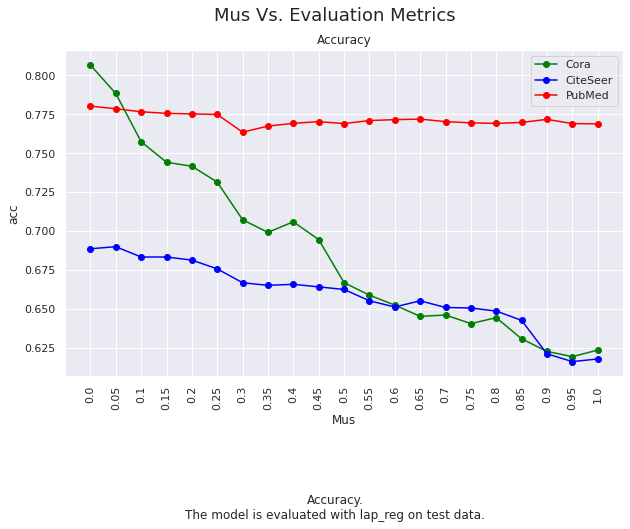

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.0
========= CiteSeer:
    acc best Mus on test: 0.05
========= PubMed:
    acc best Mus on test: 0.0


#### CP-Reg 
Fixed A, B and Seed with different Mus. 

In [ ]:
# set parameters
model_name = 'GCN'
reg_loss ='cp_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with cp_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.2080, best_epoch: 127, break_epoch: 200
    Test_acc: 0.8066
23%: mu= 0.2500, train_loss: 0.3506, best_epoch: 141, break_epoch: 200
    Test_acc: 0.8053
47%: mu= 0.5000, train_loss: 0.3735, best_epoch: 177, break_epoch: 200
    Test_acc: 0.8049
71%: mu= 0.7500, train_loss: 0.4456, best_epoch: 180, break_epoch: 200
    Test_acc: 0.8007
95%: mu= 1.0000, train_loss: 0.5239, best_epoch: 193, break_epoch: 200
    Test_acc: 0.7260
CiteSeer:
0%: mu= 0.0000, train_loss: 0.6003, best_epoch: 61, break_epoch: 162
    Test_acc: 0.6888
23%: mu= 0.2500, train_loss: 0.6566, best_epoch: 93, break_epoch: 194
    Test_acc: 0.6974
47%: mu= 0.5000, train_loss: 0.5053, best_epoch: 192, break_epoch: 200
    Test_acc: 0.7080
71%: mu= 0.7500, train_loss: 0.6193, best_epoch: 184, break_epoch: 200
    Test_acc: 0.3826
95%: mu= 1.0000, train_loss: 0.6635, best_epoch: 197, break_epoch: 200
    Test_acc: 0.3039
PubMed:
0%: mu= 0.0000, t

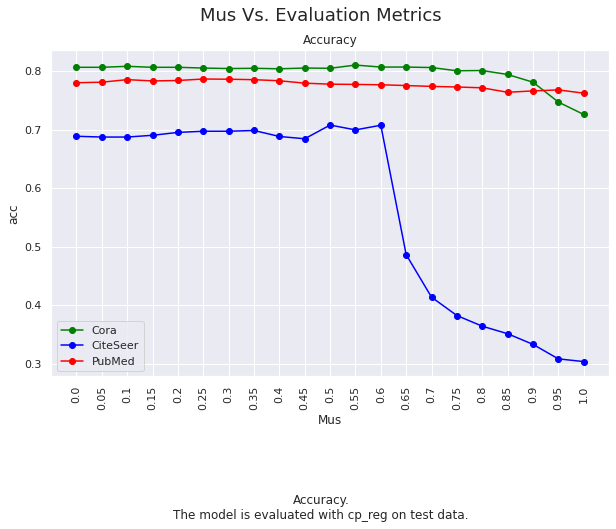

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.55
========= CiteSeer:
    acc best Mus on test: 0.5
========= PubMed:
    acc best Mus on test: 0.25


#### Label Smoothing
Fixed A, B and Seed with different Mus.

In [ ]:
# set parameters
model_name = 'GCN'
reg_loss='ls_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)[0:-1]

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with ls_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.2080, best_epoch: 127, break_epoch: 200
    Test_acc: 0.8066
25%: mu= 0.2500, train_loss: 1.1047, best_epoch: 147, break_epoch: 200
    Test_acc: 0.8092
50%: mu= 0.5000, train_loss: 1.6530, best_epoch: 100, break_epoch: 200
    Test_acc: 0.8079
75%: mu= 0.7500, train_loss: 1.9286, best_epoch: 129, break_epoch: 200
    Test_acc: 0.6836
CiteSeer:
0%: mu= 0.0000, train_loss: 0.6003, best_epoch: 61, break_epoch: 162
    Test_acc: 0.6888
25%: mu= 0.2500, train_loss: 1.2078, best_epoch: 59, break_epoch: 160
    Test_acc: 0.6905
50%: mu= 0.5000, train_loss: 1.5776, best_epoch: 95, break_epoch: 196
    Test_acc: 0.6984
75%: mu= 0.7500, train_loss: 1.7898, best_epoch: 8, break_epoch: 109
    Test_acc: 0.3902
PubMed:
0%: mu= 0.0000, train_loss: 0.2099, best_epoch: 58, break_epoch: 159
    Test_acc: 0.7803
25%: mu= 0.2500, train_loss: 0.8225, best_epoch: 34, break_epoch: 135
    Test_acc: 0.7829
50%: mu= 0.5000, train_

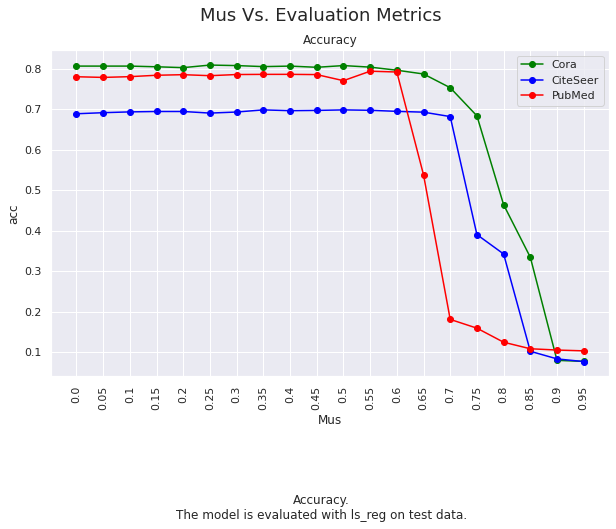

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.25
========= CiteSeer:
    acc best Mus on test: 0.35
========= PubMed:
    acc best Mus on test: 0.55


## GAT

#### P-Reg
Fixed A, B and Seed with different Mus

In [ ]:
# set parameters
model_name = 'GAT'
reg_loss ='p_reg'
p_reg_phi = 'cross_entropy'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss, p_reg_phi = p_reg_phi
                                                   )

Training with p_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.5892, best_epoch: 118, break_epoch: 200
    Test_acc: 0.8151
23%: mu= 0.2500, train_loss: 0.8236, best_epoch: 191, break_epoch: 200
    Test_acc: 0.8244
47%: mu= 0.5000, train_loss: 1.4344, best_epoch: 147, break_epoch: 200
    Test_acc: 0.8087
71%: mu= 0.7500, train_loss: 1.8763, best_epoch: 71, break_epoch: 172
    Test_acc: 0.7693
95%: mu= 1.0000, train_loss: 2.1739, best_epoch: 70, break_epoch: 171
    Test_acc: 0.6298
CiteSeer:
0%: mu= 0.0000, train_loss: 0.8392, best_epoch: 91, break_epoch: 192
    Test_acc: 0.6951
23%: mu= 0.2500, train_loss: 1.3950, best_epoch: 39, break_epoch: 140
    Test_acc: 0.7086
47%: mu= 0.5000, train_loss: 1.6840, best_epoch: 53, break_epoch: 154
    Test_acc: 0.6971
71%: mu= 0.7500, train_loss: 2.2146, best_epoch: 39, break_epoch: 140
    Test_acc: 0.6951
95%: mu= 1.0000, train_loss: 2.4127, best_epoch: 49, break_epoch: 150
    Test_acc: 0.5421
PubMed:
0%: mu= 0.0000, train_l

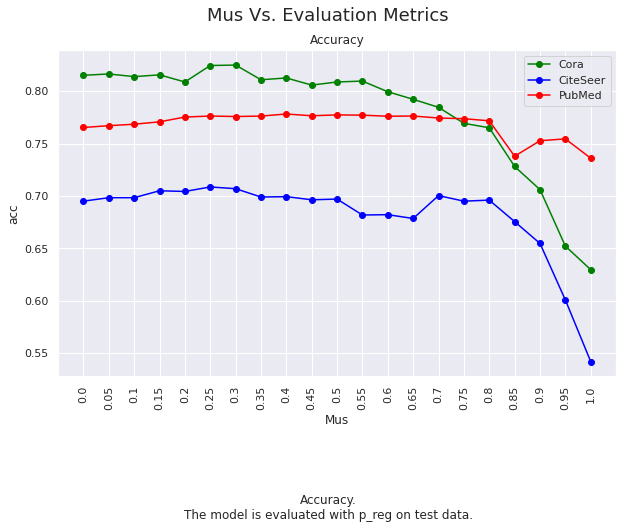

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.3
========= CiteSeer:
    acc best Mus on test: 0.25
========= PubMed:
    acc best Mus on test: 0.4


#### Lap-Reg
Fixed A, B and Seed with different Mus

In [ ]:
# set parameters
model_name = 'GAT'
reg_loss ='lap_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)


In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with lap_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.6059, best_epoch: 145, break_epoch: 200
    Test_acc: 0.8219
23%: mu= 0.2500, train_loss: 1.4492, best_epoch: 27, break_epoch: 128
    Test_acc: 0.7243
47%: mu= 0.5000, train_loss: 1.5608, best_epoch: 26, break_epoch: 127
    Test_acc: 0.6794
71%: mu= 0.7500, train_loss: 1.6375, best_epoch: 20, break_epoch: 121
    Test_acc: 0.6289
95%: mu= 1.0000, train_loss: 1.7160, best_epoch: 19, break_epoch: 120
    Test_acc: 0.6031
CiteSeer:
0%: mu= 0.0000, train_loss: 0.8392, best_epoch: 91, break_epoch: 192
    Test_acc: 0.6951
23%: mu= 0.2500, train_loss: 1.3143, best_epoch: 30, break_epoch: 131
    Test_acc: 0.6885
47%: mu= 0.5000, train_loss: 1.5212, best_epoch: 18, break_epoch: 119
    Test_acc: 0.6677
71%: mu= 0.7500, train_loss: 1.6002, best_epoch: 14, break_epoch: 115
    Test_acc: 0.6630
95%: mu= 1.0000, train_loss: 1.6145, best_epoch: 14, break_epoch: 115
    Test_acc: 0.6548
PubMed:
0%: mu= 0.0000, train_l

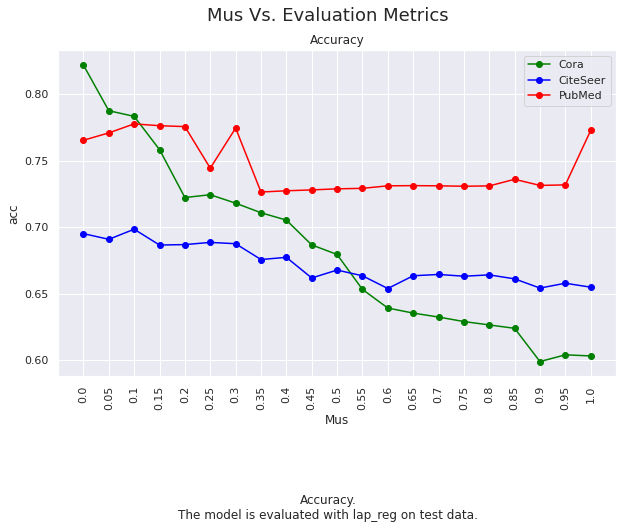

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.0
========= CiteSeer:
    acc best Mus on test: 0.1
========= PubMed:
    acc best Mus on test: 0.1


#### CP-Reg 
Fixed A, B and Seed with different Mus. 

In [ ]:
# set parameters
model_name = 'GAT'
reg_loss ='cp_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with cp_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.5892, best_epoch: 118, break_epoch: 200
    Test_acc: 0.8151
23%: mu= 0.2500, train_loss: 0.9830, best_epoch: 69, break_epoch: 170
    Test_acc: 0.8126
47%: mu= 0.5000, train_loss: 1.2230, best_epoch: 70, break_epoch: 171
    Test_acc: 0.8062
71%: mu= 0.7500, train_loss: 1.2232, best_epoch: 116, break_epoch: 200
    Test_acc: 0.8066
95%: mu= 1.0000, train_loss: 1.3515, best_epoch: 115, break_epoch: 200
    Test_acc: 0.7570
CiteSeer:
0%: mu= 0.0000, train_loss: 0.8392, best_epoch: 91, break_epoch: 192
    Test_acc: 0.6951
23%: mu= 0.2500, train_loss: 1.1170, best_epoch: 89, break_epoch: 190
    Test_acc: 0.7010
47%: mu= 0.5000, train_loss: 1.4656, best_epoch: 55, break_epoch: 156
    Test_acc: 0.7076
71%: mu= 0.7500, train_loss: 1.3904, best_epoch: 195, break_epoch: 200
    Test_acc: 0.5458
95%: mu= 1.0000, train_loss: 1.4322, best_epoch: 193, break_epoch: 200
    Test_acc: 0.4651
PubMed:
0%: mu= 0.0000, trai

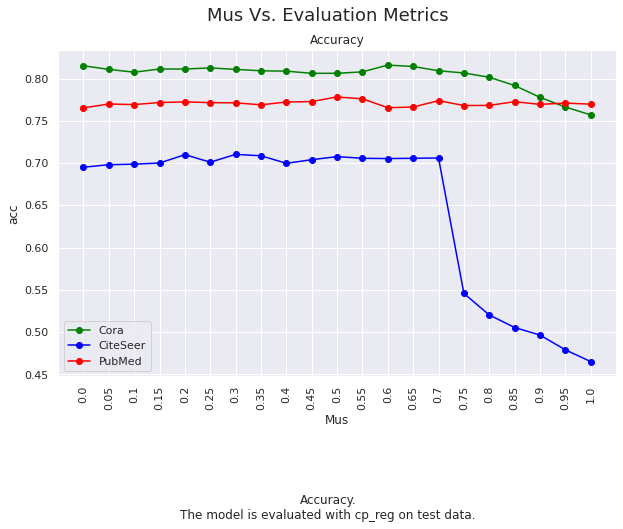

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.6
========= CiteSeer:
    acc best Mus on test: 0.3
========= PubMed:
    acc best Mus on test: 0.5


#### Label Smoothing
Fixed A, B and Seed with different Mus.

In [ ]:
# set parameters
model_name = 'GAT'
reg_loss='ls_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)[0:-1]


In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with ls_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.6059, best_epoch: 145, break_epoch: 200
    Test_acc: 0.8219
25%: mu= 0.2500, train_loss: 1.4164, best_epoch: 119, break_epoch: 200
    Test_acc: 0.8168
50%: mu= 0.5000, train_loss: 1.7657, best_epoch: 117, break_epoch: 200
    Test_acc: 0.8121
75%: mu= 0.7500, train_loss: 1.9345, best_epoch: 28, break_epoch: 129
    Test_acc: 0.6637
CiteSeer:
0%: mu= 0.0000, train_loss: 0.8392, best_epoch: 91, break_epoch: 192
    Test_acc: 0.6951
25%: mu= 0.2500, train_loss: 1.3565, best_epoch: 49, break_epoch: 150
    Test_acc: 0.7000
50%: mu= 0.5000, train_loss: 1.6816, best_epoch: 40, break_epoch: 141
    Test_acc: 0.6878
75%: mu= 0.7500, train_loss: 1.7890, best_epoch: 6, break_epoch: 107
    Test_acc: 0.6792
PubMed:
0%: mu= 0.0000, train_loss: 0.4607, best_epoch: 72, break_epoch: 173
    Test_acc: 0.7653
25%: mu= 0.2500, train_loss: 0.9130, best_epoch: 38, break_epoch: 139
    Test_acc: 0.7760
50%: mu= 0.5000, train_l

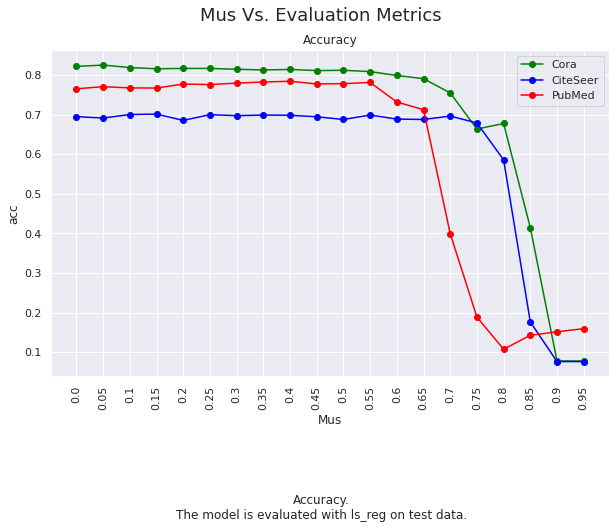

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.05
========= CiteSeer:
    acc best Mus on test: 0.15
========= PubMed:
    acc best Mus on test: 0.4


## MLP

#### P-Reg
Fixed A, B and Seed with different Mus

In [ ]:
# set parameters
model_name = 'MLP'
reg_loss ='p_reg'
p_reg_phi = 'cross_entropy'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss, p_reg_phi = p_reg_phi
                                                   )

Training with p_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.1015, best_epoch: 174, break_epoch: 200
    Test_acc: 0.5886
23%: mu= 0.2500, train_loss: 0.7385, best_epoch: 51, break_epoch: 152
    Test_acc: 0.4796
47%: mu= 0.5000, train_loss: 1.8503, best_epoch: 28, break_epoch: 129
    Test_acc: 0.3524
71%: mu= 0.7500, train_loss: 1.2347, best_epoch: 48, break_epoch: 149
    Test_acc: 0.3202
95%: mu= 1.0000, train_loss: 3.8812, best_epoch: 1, break_epoch: 102
    Test_acc: 0.3126
CiteSeer:
0%: mu= 0.0000, train_loss: 0.1871, best_epoch: 97, break_epoch: 198
    Test_acc: 0.5765
23%: mu= 0.2500, train_loss: 0.8044, best_epoch: 49, break_epoch: 150
    Test_acc: 0.4850
47%: mu= 0.5000, train_loss: 2.6451, best_epoch: 4, break_epoch: 105
    Test_acc: 0.3053
71%: mu= 0.7500, train_loss: 3.0922, best_epoch: 4, break_epoch: 105
    Test_acc: 0.3095
95%: mu= 1.0000, train_loss: 3.5394, best_epoch: 4, break_epoch: 105
    Test_acc: 0.3099
PubMed:
0%: mu= 0.0000, train_loss: 0

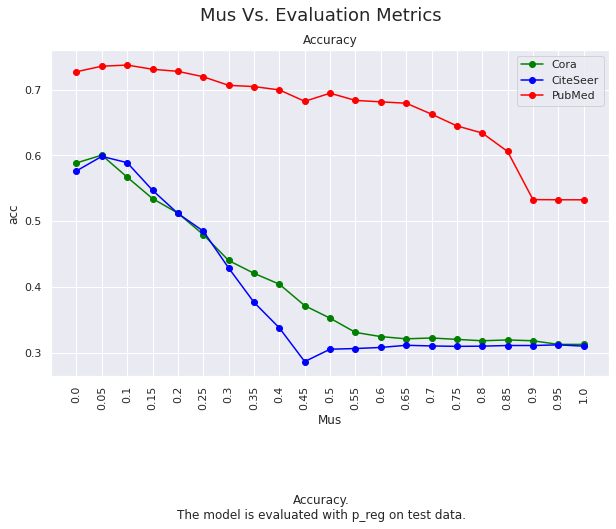

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.05
========= CiteSeer:
    acc best Mus on test: 0.05
========= PubMed:
    acc best Mus on test: 0.1


#### Lap-Reg
Fixed A, B and Seed with different Mus

In [ ]:
# set parameters
model_name = 'MLP'
reg_loss ='lap_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)


In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with lap_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.1015, best_epoch: 174, break_epoch: 200
    Test_acc: 0.5886
23%: mu= 0.2500, train_loss: 0.8873, best_epoch: 64, break_epoch: 165
    Test_acc: 0.6056
47%: mu= 0.5000, train_loss: 1.2062, best_epoch: 43, break_epoch: 144
    Test_acc: 0.5505
71%: mu= 0.7500, train_loss: 1.1266, best_epoch: 60, break_epoch: 161
    Test_acc: 0.5148
95%: mu= 1.0000, train_loss: 1.3177, best_epoch: 50, break_epoch: 151
    Test_acc: 0.5004
CiteSeer:
0%: mu= 0.0000, train_loss: 0.1871, best_epoch: 97, break_epoch: 198
    Test_acc: 0.5765
23%: mu= 0.2500, train_loss: 0.5380, best_epoch: 127, break_epoch: 200
    Test_acc: 0.5841
47%: mu= 0.5000, train_loss: 0.8014, best_epoch: 72, break_epoch: 173
    Test_acc: 0.5600
71%: mu= 0.7500, train_loss: 0.8376, best_epoch: 71, break_epoch: 172
    Test_acc: 0.5335
95%: mu= 1.0000, train_loss: 1.0744, best_epoch: 49, break_epoch: 150
    Test_acc: 0.5329
PubMed:
0%: mu= 0.0000, train_

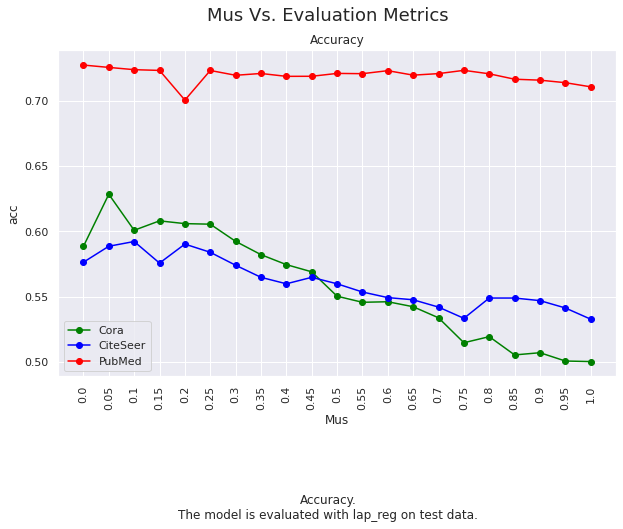

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.05
========= CiteSeer:
    acc best Mus on test: 0.1
========= PubMed:
    acc best Mus on test: 0.0


#### CP-Reg 
Fixed A, B and Seed with different Mus. 

In [ ]:
# set parameters
model_name = 'MLP'
reg_loss ='cp_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with cp_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.1015, best_epoch: 174, break_epoch: 200
    Test_acc: 0.5886
23%: mu= 0.2500, train_loss: 0.4131, best_epoch: 81, break_epoch: 182
    Test_acc: 0.4932
47%: mu= 0.5000, train_loss: 0.3930, best_epoch: 104, break_epoch: 200
    Test_acc: 0.3656
71%: mu= 0.7500, train_loss: 0.3536, best_epoch: 136, break_epoch: 200
    Test_acc: 0.3456
95%: mu= 1.0000, train_loss: 0.4097, best_epoch: 135, break_epoch: 200
    Test_acc: 0.3367
CiteSeer:
0%: mu= 0.0000, train_loss: 0.1871, best_epoch: 97, break_epoch: 198
    Test_acc: 0.5765
23%: mu= 0.2500, train_loss: 0.7574, best_epoch: 47, break_epoch: 148
    Test_acc: 0.4932
47%: mu= 0.5000, train_loss: 2.6450, best_epoch: 4, break_epoch: 105
    Test_acc: 0.3049
71%: mu= 0.7500, train_loss: 3.0920, best_epoch: 4, break_epoch: 105
    Test_acc: 0.3109
95%: mu= 1.0000, train_loss: 3.5390, best_epoch: 4, break_epoch: 105
    Test_acc: 0.3102
PubMed:
0%: mu= 0.0000, train_lo

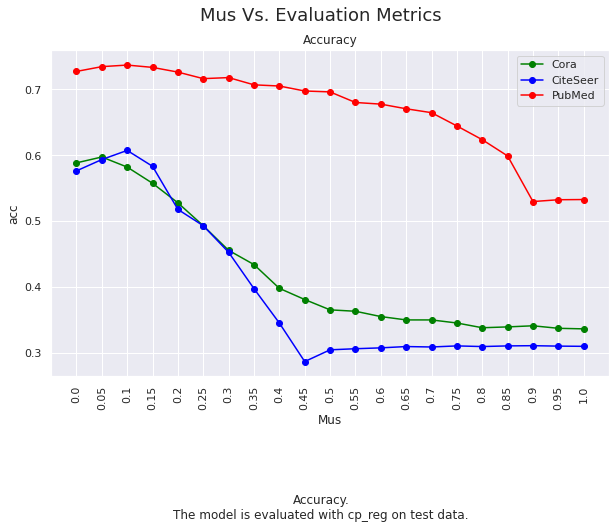

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.05
========= CiteSeer:
    acc best Mus on test: 0.1
========= PubMed:
    acc best Mus on test: 0.1


#### Label Smoothing
Fixed A, B and Seed with different Mus.

In [ ]:
# set parameters
model_name = 'MLP'
reg_loss='ls_reg'
A, B, seed = 20, 30, 0 
mus = np.linspace(0,1,21)[0:-1]

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus,
                                                   model_name = model_name, reg_loss = reg_loss
                                                   )

Training with ls_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.1015, best_epoch: 174, break_epoch: 200
    Test_acc: 0.5886
25%: mu= 0.2500, train_loss: 1.0910, best_epoch: 119, break_epoch: 200
    Test_acc: 0.5958
50%: mu= 0.5000, train_loss: 1.6484, best_epoch: 67, break_epoch: 168
    Test_acc: 0.5852
75%: mu= 0.7500, train_loss: 1.9211, best_epoch: 191, break_epoch: 200
    Test_acc: 0.5657
CiteSeer:
0%: mu= 0.0000, train_loss: 0.1871, best_epoch: 97, break_epoch: 198
    Test_acc: 0.5765
25%: mu= 0.2500, train_loss: 1.0938, best_epoch: 57, break_epoch: 158
    Test_acc: 0.5765
50%: mu= 0.5000, train_loss: 1.5555, best_epoch: 59, break_epoch: 160
    Test_acc: 0.5887
75%: mu= 0.7500, train_loss: 1.7820, best_epoch: 151, break_epoch: 200
    Test_acc: 0.5963
PubMed:
0%: mu= 0.0000, train_loss: 0.0739, best_epoch: 77, break_epoch: 178
    Test_acc: 0.7274
25%: mu= 0.2500, train_loss: 0.7653, best_epoch: 39, break_epoch: 140
    Test_acc: 0.7235
50%: mu= 0.5000, train

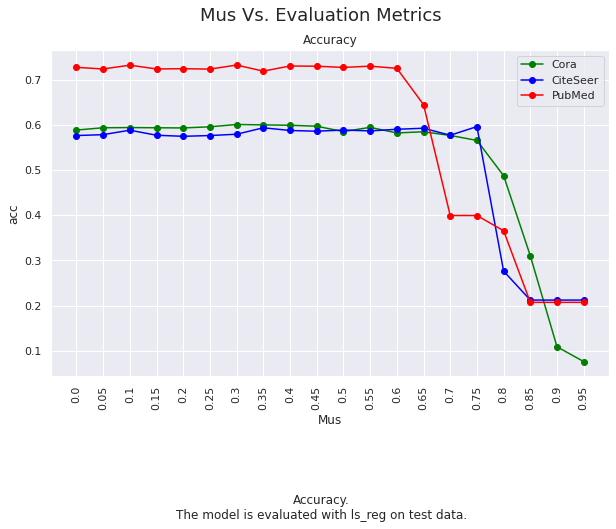

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.3
========= CiteSeer:
    acc best Mus on test: 0.75
========= PubMed:
    acc best Mus on test: 0.3


# Table 01


## Table Function

In [ ]:
def table(  A = None, # int 
            B = None, # int 
            seeds = None, # float list 
            reg_loss = None, # str: 'p_reg', 'lap_reg', 'cp_reg', 'no_reg' 
            p_reg_phi = None, # str: 'cross_entropy', 'squared_error', 'kl_divergence'
            model_name = 'GCN', # str: 'GCN','GAT','MLP'
            dataset_mus = {'Cora': None, 'CiteSeer': None, 'PubMed': None}, # dict: dataset_Name:str -> mu:folat
            epochs = 200, # int
            patience = 100, # int 
            verbose = True, # bolean
        ):

    # check reg_loss input arg.
    if reg_loss is not None:
        assert reg_loss in ['p_reg', 'lap_reg', 'cp_reg', 'ls_reg', 'no_reg'], "check reg_losse arg."    
        if reg_loss == 'no_reg':
            for dataset_Name in dataset_mus.keys():
                dataset_mus[dataset_Name] == 0, "mu should be 0"
            
 
    # check p_reg_phi input arg.
    if p_reg_phi is not None:
        assert p_reg_phi in ['cross_entropy', 'squared_error', 'kl_divergence'], 'check p_reg_phi arg.'
        assert reg_loss == 'p_reg' , "reg_loss should be p_reg'"


    # Start Training
    if verbose: print(f'Training with {reg_loss} with different "Seeds":')

    # evaluation Storage
    Results = {}
    
    # loop over datasets
    for dataset_name in dataset_mus.keys(): 
        # define dataset
        if verbose: print(f'========================= {dataset_name}:')
        dataset = load_dataset(dataset_name)
        
        # define data
        data = dataset[0]
        data = data.to(device)

        # define mu
        mu = dataset_mus[dataset_name]
        print(f'µ = {mu}')

        # calc number of classes
        num_classes = dataset.num_classes
        
        # calc A_hat as it's training invariant 
        if reg_loss == 'p_reg':
            A_hat, A_hat_mask, N = A_hat_computations(data)
            p_reg_dict = {'A_hat': A_hat, 
                          'A_hat_mask': A_hat_mask, 
                          'N': N, 
                          'phi': 'cross_entropy' if p_reg_phi is None else p_reg_phi}  
        else: 
            p_reg_dict = None

        # define test evaluation metrices
        Results[dataset_name+'_acc' ] = []

        # loop over params
        for i in range(len(seeds)):
            # define seed
            seed = seeds[i]
            torch.manual_seed(seed)

            # calc the split
            if (A is not None) & (B is not None):
                train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                train_mask = train_mask.to(device)
                val_mask = val_mask.to(device)
                test_mask = test_mask.to(device)
                assert sum(train_mask)  == num_classes*A
                assert sum(val_mask)  == num_classes*B
            else:
                train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

            # define MOC
            if model_name == 'GCN':
                model = GCN(dataset, hidden_channels=64, seed = seed).to(device) # 16 , 64 
            elif model_name == 'GAT':
                model = GAT(dataset, hidden_channels=16, seed = seed).to(device) # 8 , 16
            elif model_name == 'MLP':
                model = MLP(dataset, hidden_channels=64, seed = seed).to(device) # 16 , 64       
            else: 
                raise NotImplementedError('Only GCA, GAT and MLP models are supported')
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            # loop over epochs
            Val_Acc, Train_Loss, Epoch, Break_Epoch  = -np.inf, -np.inf, -1, -1
            for epoch in range(epochs):
                # train
                train_loss = train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict, num_classes)   
                # test
                with torch.no_grad():
                    val_acc = test(model, data, val_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)

                    if val_acc > Val_Acc: 
                        test_acc = test(model, data, test_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)
                        Epoch, Train_Loss, Val_Acc, Test_Acc = epoch, train_loss , val_acc, test_acc
                        wait = 0
                    else:
                        wait += 1
                    
                    if wait > patience: 
                        Break_Epoch = epoch
                        break 

            # save test metrices, loss and embadding
            Results[dataset_name+'_acc' ].append(Test_Acc)
            
            # Print 
            condition = ((verbose) & (i % 2 == 0)) if (len(seeds) < 10) else ((verbose) & (i % 5 == 0))
            precent = int(i/len(seeds)*100)
            if condition:
                Break_Epoch = epochs if Break_Epoch == -1 else Break_Epoch
                print(f'{precent}%: seed= {seed}, train_loss: {Train_Loss:.4f}, best_epoch: {Epoch}, break_epoch: {Break_Epoch}')
                print(f'    Test_acc: {Test_Acc:.4f}')


    return Results

## Initilze Table

In [ ]:
class table_class:
    def __init__(self,):
        self.table = pd.DataFrame(columns=self.row())

    def row(self, Model=None, Regulization=None):
        data = dict.fromkeys(['Model', 'Regulization', 
                            'Cora_mean', 'Cora_std',
                            'CiteSeer_mean', 'CiteSeer_std', 
                            'PubMed_mean','PubMed_std'])
        if Model: data['Model'] = Model
        if Regulization: data['Regulization'] = Regulization
        return data  
    
    def update(self, model_name, reg_loss, Results, verbose=True):
        idx = ['p_reg', 'lap_reg', 'cp_reg', 'ls_reg', 'no_reg'].index(reg_loss)
        reg_loss = ['P-reg ', 'Laplacian Regularizer', 'Confidence Penalty', 'Label Smoothing', 'Vanilla'][idx]
        data = self.row(Model=model_name, Regulization=reg_loss)
        for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
            data[f'{dataset_Name}_mean'] = np.mean(Results[f'{dataset_Name}_acc']) 
            data[f'{dataset_Name}_std'] = np.std(Results[f'{dataset_Name}_acc']) 
        self.table = self.table.append(data, ignore_index = True)
        self.table = self.table.drop_duplicates(subset=['Model', 'Regulization'])
        if verbose: display(self.table.tail(1))

# init Table 01
Table_01 = table_class()

## GCN

#### Vanilla

In [ ]:
# set parameters 
model_name = 'GCN'
reg_loss = 'no_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0, 'PubMed':0} # No reg
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

Training with no_reg with different "Seeds":
========================= Cora:
µ = 0
0%: seed= 0, train_loss: 0.1782, best_epoch: 156, break_epoch: 200
    Test_acc: 0.8041
25%: seed= 5, train_loss: 0.1830, best_epoch: 162, break_epoch: 200
    Test_acc: 0.8181
50%: seed= 10, train_loss: 0.2312, best_epoch: 120, break_epoch: 200
    Test_acc: 0.8130
75%: seed= 15, train_loss: 0.2101, best_epoch: 138, break_epoch: 200
    Test_acc: 0.8109
========================= CiteSeer:
µ = 0
0%: seed= 0, train_loss: 0.6122, best_epoch: 56, break_epoch: 157
    Test_acc: 0.6878
25%: seed= 5, train_loss: 0.7407, best_epoch: 49, break_epoch: 150
    Test_acc: 0.6984
50%: seed= 10, train_loss: 0.6418, best_epoch: 50, break_epoch: 151
    Test_acc: 0.7020
75%: seed= 15, train_loss: 0.9044, best_epoch: 40, break_epoch: 141
    Test_acc: 0.6981
========================= PubMed:
µ = 0
0%: seed= 0, train_loss: 0.1985, best_epoch: 60, break_epoch: 161
    Test_acc: 0.7820
25%: seed= 5, train_loss: 0.1338, best

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
0,GCN,Vanilla,0.814334,0.00581,0.698761,0.005742,0.781091,0.007463


#### Label Smoothing

In [ ]:
# set parameters 
model_name = 'GCN'
reg_loss = 'ls_reg'
dataset_mus = {'Cora': 0.25, 'CiteSeer':0.35, 'PubMed':0.55} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

Training with ls_reg with different "Seeds":
========================= Cora:
µ = 0.25
0%: seed= 0, train_loss: 1.1173, best_epoch: 106, break_epoch: 200
    Test_acc: 0.8041
25%: seed= 5, train_loss: 1.1020, best_epoch: 175, break_epoch: 200
    Test_acc: 0.8185
50%: seed= 10, train_loss: 1.2381, best_epoch: 48, break_epoch: 149
    Test_acc: 0.8121
75%: seed= 15, train_loss: 1.1995, best_epoch: 53, break_epoch: 154
    Test_acc: 0.8202
========================= CiteSeer:
µ = 0.35
0%: seed= 0, train_loss: 1.3685, best_epoch: 71, break_epoch: 172
    Test_acc: 0.6941
25%: seed= 5, train_loss: 1.3096, best_epoch: 154, break_epoch: 200
    Test_acc: 0.6994
50%: seed= 10, train_loss: 1.4993, best_epoch: 35, break_epoch: 136
    Test_acc: 0.7063
75%: seed= 15, train_loss: 1.3207, best_epoch: 112, break_epoch: 200
    Test_acc: 0.7020
========================= PubMed:
µ = 0.55
0%: seed= 0, train_loss: 1.0795, best_epoch: 29, break_epoch: 130
    Test_acc: 0.7884
25%: seed= 5, train_loss: 1.0

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
1,GCN,Label Smoothing,0.81408,0.006177,0.700942,0.005333,0.783084,0.008513


#### Confidence Penalty

In [ ]:
# set parameters 
model_name = 'GCN'
reg_loss = 'cp_reg'
dataset_mus = {'Cora': 0.55, 'CiteSeer':0.5, 'PubMed':0.25} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

Training with cp_reg with different "Seeds":
========================= Cora:
µ = 0.55
0%: seed= 0, train_loss: 0.4909, best_epoch: 129, break_epoch: 200
    Test_acc: 0.8126
25%: seed= 5, train_loss: 0.3808, best_epoch: 197, break_epoch: 200
    Test_acc: 0.8198
50%: seed= 10, train_loss: 0.5981, best_epoch: 97, break_epoch: 198
    Test_acc: 0.8113
75%: seed= 15, train_loss: 0.4214, best_epoch: 164, break_epoch: 200
    Test_acc: 0.8151
========================= CiteSeer:
µ = 0.5
0%: seed= 0, train_loss: 0.5529, best_epoch: 172, break_epoch: 200
    Test_acc: 0.7090
25%: seed= 5, train_loss: 1.0787, best_epoch: 70, break_epoch: 171
    Test_acc: 0.6964
50%: seed= 10, train_loss: 1.3078, best_epoch: 51, break_epoch: 152
    Test_acc: 0.6911
75%: seed= 15, train_loss: 1.0977, best_epoch: 65, break_epoch: 166
    Test_acc: 0.6954
========================= PubMed:
µ = 0.25
0%: seed= 0, train_loss: 0.2226, best_epoch: 112, break_epoch: 200
    Test_acc: 0.7855
25%: seed= 5, train_loss: 0.2

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
2,GCN,Confidence Penalty,0.813889,0.008954,0.692517,0.044461,0.783656,0.008739


#### Laplacian Regularization

In [ ]:
# set parameters 
model_name = 'GCN'
reg_loss = 'lap_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0.05, 'PubMed':0} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

Training with lap_reg with different "Seeds":
========================= Cora:
µ = 0
0%: seed= 0, train_loss: 0.1781, best_epoch: 156, break_epoch: 200
    Test_acc: 0.8041
25%: seed= 5, train_loss: 0.1830, best_epoch: 162, break_epoch: 200
    Test_acc: 0.8181
50%: seed= 10, train_loss: 0.2312, best_epoch: 120, break_epoch: 200
    Test_acc: 0.8130
75%: seed= 15, train_loss: 0.2101, best_epoch: 138, break_epoch: 200
    Test_acc: 0.8109
========================= CiteSeer:
µ = 0.05
0%: seed= 0, train_loss: 0.9273, best_epoch: 41, break_epoch: 142
    Test_acc: 0.6746
25%: seed= 5, train_loss: 0.6958, best_epoch: 56, break_epoch: 157
    Test_acc: 0.6951
50%: seed= 10, train_loss: 0.4368, best_epoch: 108, break_epoch: 200
    Test_acc: 0.6931
75%: seed= 15, train_loss: 0.8135, best_epoch: 45, break_epoch: 146
    Test_acc: 0.6941
========================= PubMed:
µ = 0
0%: seed= 0, train_loss: 0.1985, best_epoch: 60, break_epoch: 161
    Test_acc: 0.7820
25%: seed= 5, train_loss: 0.1338,

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
3,GCN,Laplacian Regularizer,0.814355,0.005774,0.694466,0.007207,0.781091,0.007463


#### Preg

In [ ]:
# set parameters 
model_name = 'GCN'
reg_loss = 'p_reg'
p_reg_phi = 'cross_entropy'
dataset_mus = {'Cora': 0.1, 'CiteSeer':0.4, 'PubMed':0.15} # See Analysis 03 corrected
A, B = 20, 30
seeds    = np.arange(20)


In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus, p_reg_phi = p_reg_phi
                )

Training with p_reg with different "Seeds":
========================= Cora:
µ = 0.1
0%: seed= 0, train_loss: 0.3236, best_epoch: 108, break_epoch: 200
    Test_acc: 0.8028
25%: seed= 5, train_loss: 0.2748, best_epoch: 166, break_epoch: 200
    Test_acc: 0.8176
50%: seed= 10, train_loss: 0.3596, best_epoch: 104, break_epoch: 200
    Test_acc: 0.8181
75%: seed= 15, train_loss: 0.5071, best_epoch: 61, break_epoch: 162
    Test_acc: 0.8210
========================= CiteSeer:
µ = 0.4
0%: seed= 0, train_loss: 0.5670, best_epoch: 172, break_epoch: 200
    Test_acc: 0.7093
25%: seed= 5, train_loss: 0.5286, best_epoch: 191, break_epoch: 200
    Test_acc: 0.7152
50%: seed= 10, train_loss: 1.1679, best_epoch: 54, break_epoch: 155
    Test_acc: 0.6977
75%: seed= 15, train_loss: 0.5778, best_epoch: 159, break_epoch: 200
    Test_acc: 0.7090
========================= PubMed:
µ = 0.15
0%: seed= 0, train_loss: 0.2312, best_epoch: 116, break_epoch: 200
    Test_acc: 0.7867
25%: seed= 5, train_loss: 0.4

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
4,GCN,P-reg,0.817324,0.007166,0.705583,0.018354,0.780942,0.011251


## GAT

#### Vanilla

In [ ]:
# set parameters 
model_name = 'GAT'
reg_loss = 'no_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0, 'PubMed':0} # No reg 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

Training with no_reg with different "Seeds":
========================= Cora:
µ = 0
0%: seed= 0, train_loss: 0.8349, best_epoch: 91, break_epoch: 192
    Test_acc: 0.8181
25%: seed= 5, train_loss: 0.7641, best_epoch: 70, break_epoch: 171
    Test_acc: 0.8227
50%: seed= 10, train_loss: 0.8625, best_epoch: 54, break_epoch: 155
    Test_acc: 0.8265
75%: seed= 15, train_loss: 0.6790, best_epoch: 141, break_epoch: 200
    Test_acc: 0.8325
========================= CiteSeer:
µ = 0
0%: seed= 0, train_loss: 1.0857, best_epoch: 32, break_epoch: 133
    Test_acc: 0.6994
25%: seed= 5, train_loss: 0.5703, best_epoch: 166, break_epoch: 200
    Test_acc: 0.6984
50%: seed= 10, train_loss: 0.9914, best_epoch: 38, break_epoch: 139
    Test_acc: 0.7043
75%: seed= 15, train_loss: 0.6551, best_epoch: 139, break_epoch: 200
    Test_acc: 0.6987
========================= PubMed:
µ = 0
0%: seed= 0, train_loss: 0.4555, best_epoch: 34, break_epoch: 135
    Test_acc: 0.7656
25%: seed= 5, train_loss: 0.3345, best_

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
5,GAT,Vanilla,0.826145,0.005608,0.699604,0.006797,0.771291,0.006477


#### Label Smoothing

In [ ]:
# set parameters 
model_name = 'GAT'
reg_loss = 'ls_reg'
dataset_mus = {'Cora': 0.05, 'CiteSeer':0.15, 'PubMed':0.4} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

Training with ls_reg with different "Seeds":
========================= Cora:
µ = 0.05
0%: seed= 0, train_loss: 0.8064, best_epoch: 110, break_epoch: 200
    Test_acc: 0.8189
25%: seed= 5, train_loss: 0.9199, best_epoch: 77, break_epoch: 178
    Test_acc: 0.8270
50%: seed= 10, train_loss: 0.9628, best_epoch: 49, break_epoch: 150
    Test_acc: 0.8215
75%: seed= 15, train_loss: 0.8352, best_epoch: 103, break_epoch: 200
    Test_acc: 0.8329
========================= CiteSeer:
µ = 0.15
0%: seed= 0, train_loss: 1.3424, best_epoch: 31, break_epoch: 132
    Test_acc: 0.7040
25%: seed= 5, train_loss: 1.1012, best_epoch: 186, break_epoch: 200
    Test_acc: 0.6941
50%: seed= 10, train_loss: 1.3873, best_epoch: 34, break_epoch: 135
    Test_acc: 0.7033
75%: seed= 15, train_loss: 1.2587, best_epoch: 43, break_epoch: 144
    Test_acc: 0.7033
========================= PubMed:
µ = 0.4
0%: seed= 0, train_loss: 1.0336, best_epoch: 19, break_epoch: 120
    Test_acc: 0.7646
25%: seed= 5, train_loss: 1.034

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
6,GAT,Label Smoothing,0.825318,0.005605,0.697985,0.008771,0.770397,0.014189


#### Confidence Penalty

In [ ]:
# set parameters 
model_name = 'GAT'
reg_loss = 'cp_reg'
dataset_mus = {'Cora': 0.6, 'CiteSeer':0.3, 'PubMed':0.5} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

Training with cp_reg with different "Seeds":
========================= Cora:
µ = 0.6
0%: seed= 0, train_loss: 1.4109, best_epoch: 57, break_epoch: 158
    Test_acc: 0.7791
25%: seed= 5, train_loss: 1.5643, best_epoch: 53, break_epoch: 154
    Test_acc: 0.7833
50%: seed= 10, train_loss: 1.2123, best_epoch: 80, break_epoch: 181
    Test_acc: 0.8210
75%: seed= 15, train_loss: 1.1630, best_epoch: 105, break_epoch: 200
    Test_acc: 0.8270
========================= CiteSeer:
µ = 0.3
0%: seed= 0, train_loss: 1.5756, best_epoch: 38, break_epoch: 139
    Test_acc: 0.7030
25%: seed= 5, train_loss: 0.8443, best_epoch: 166, break_epoch: 200
    Test_acc: 0.7096
50%: seed= 10, train_loss: 1.3530, best_epoch: 49, break_epoch: 150
    Test_acc: 0.7099
75%: seed= 15, train_loss: 0.9831, best_epoch: 104, break_epoch: 200
    Test_acc: 0.7023
========================= PubMed:
µ = 0.5
0%: seed= 0, train_loss: 0.7652, best_epoch: 50, break_epoch: 151
    Test_acc: 0.7678
25%: seed= 5, train_loss: 0.5573,

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

# 8	GAT	Confidence Penalty	0.803414	0.028668	0.705434	0.0105	0.775395	0.010394

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
7,GAT,Confidence Penalty,0.79525,0.032618,0.704922,0.009277,0.774319,0.011339


#### Laplacian Regularization

In [ ]:
# set parameters 
model_name = 'GAT'
reg_loss = 'lap_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0.1, 'PubMed':0.1} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

Training with lap_reg with different "Seeds":
========================= Cora:
µ = 0
0%: seed= 0, train_loss: 0.8349, best_epoch: 91, break_epoch: 192
    Test_acc: 0.8181
25%: seed= 5, train_loss: 0.7641, best_epoch: 70, break_epoch: 171
    Test_acc: 0.8227
50%: seed= 10, train_loss: 0.8625, best_epoch: 54, break_epoch: 155
    Test_acc: 0.8265
75%: seed= 15, train_loss: 0.6790, best_epoch: 141, break_epoch: 200
    Test_acc: 0.8325
========================= CiteSeer:
µ = 0.1
0%: seed= 0, train_loss: 1.2196, best_epoch: 33, break_epoch: 134
    Test_acc: 0.7027
25%: seed= 5, train_loss: 1.0548, best_epoch: 47, break_epoch: 148
    Test_acc: 0.7090
50%: seed= 10, train_loss: 1.2317, best_epoch: 32, break_epoch: 133
    Test_acc: 0.7037
75%: seed= 15, train_loss: 1.2853, best_epoch: 29, break_epoch: 130
    Test_acc: 0.6792
========================= PubMed:
µ = 0.1
0%: seed= 0, train_loss: 0.6749, best_epoch: 27, break_epoch: 128
    Test_acc: 0.7646
25%: seed= 5, train_loss: 0.7487, be

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

,Model,Regulization,Cora_mean,Cora_std,CiteSeer_mean,CiteSeer_std,PubMed_mean,PubMed_std
8,GAT,Laplacian Regularizer,0.826145,0.005603,0.689445,0.014354,0.767213,0.008996


#### Preg

In [ ]:
# set parameters 
model_name = 'GAT'
reg_loss = 'p_reg'
p_reg_phi = 'cross_entropy'
dataset_mus = {'Cora': 0.3, 'CiteSeer':0.25, 'PubMed':0.4} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus, p_reg_phi = p_reg_phi
                )

Training with p_reg with different "Seeds":
========================= Cora:
µ = 0.3
0%: seed= 0, train_loss: 1.0756, best_epoch: 112, break_epoch: 200
    Test_acc: 0.8164
25%: seed= 5, train_loss: 1.0185, best_epoch: 122, break_epoch: 200
    Test_acc: 0.8321
50%: seed= 10, train_loss: 1.3295, best_epoch: 54, break_epoch: 155
    Test_acc: 0.8236


In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

## MLP

#### Vanilla

In [ ]:
# set parameters 
model_name = 'MLP'
reg_loss = 'no_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0, 'PubMed':0} # No reg 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

#### Label Smoothing

In [ ]:
# set parameters 
model_name = 'MLP'
reg_loss = 'ls_reg'
dataset_mus = {'Cora': 0.3, 'CiteSeer':0.65, 'PubMed':0.3} # See Analysis 03 + corrected 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

#### Confidence Penalty

In [ ]:
# set parameters 
model_name = 'MLP'
reg_loss = 'cp_reg'
dataset_mus = {'Cora': 0.05, 'CiteSeer':0.1, 'PubMed':0.1} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

#### Laplacian Regularization

In [ ]:
# set parameters 
model_name = 'MLP'
reg_loss = 'lap_reg'
dataset_mus = {'Cora': 0.05, 'CiteSeer':0.1, 'PubMed':0} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus,
                )

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

#### Preg

In [ ]:
# set parameters 
model_name = 'MLP'
reg_loss = 'p_reg'
p_reg_phi = 'cross_entropy'
dataset_mus = {'Cora': 0.05, 'CiteSeer':0.05, 'PubMed':0.1} # See Analysis 03 
A, B = 20, 30
seeds    = np.arange(20)

In [ ]:
# train and evaluate 
Results = table(A = A, B = B, seeds = seeds, 
                model_name = model_name, reg_loss = reg_loss, dataset_mus = dataset_mus, p_reg_phi = p_reg_phi
                )

In [ ]:
# update table
Table_01.update(model_name, reg_loss, Results)

## Results

In [118]:
path = !pwd
path = path[0] + '/Table01.csv'
# Table_01.table.to_csv(path, index=False)
Table_01_01 = pd.read_csv(path)

In [120]:
Table_01.table.round(decimals=2).groupby(['Model','Regulization']).first()

Cora_mean  Cora_std  CiteSeer_mean  CiteSeer_std  \
Model Regulization                                                              
GAT   Confidence Penalty          0.80      0.03           0.70          0.01   
      Label Smoothing             0.83      0.01           0.70          0.01   
      Laplacian Regularizer       0.83      0.01           0.69          0.01   
      P-reg                       0.83      0.01           0.70          0.01   
      Vanilla                     0.83      0.01           0.70          0.01   
GCN   Confidence Penalty          0.81      0.01           0.69          0.04   
      Label Smoothing             0.81      0.01           0.70          0.01   
      Laplacian Regularizer       0.81      0.01           0.69          0.01   
      P-reg                       0.82      0.01           0.71          0.02   
      Vanilla                     0.81      0.01           0.70          0.01   
MLP   Confidence Penalty          0.61      0.01           0.58          0.03   
      Label Smoothing             0.61      0.01           0.59          0.01   
      Laplacian Regularizer       0.64      0.02           0.59          0.02   
      P-reg                       0.62      0.01           0.59          0.02   
      Vanilla                     0.60      0.01           0.58          0.02   

                             PubMed_mean  PubMed_std  
Model Regulization                                    
GAT   Confidence Penalty            0.77        0.01  
      Label Smoothing               0.77        0.01  
      Laplacian Regularizer         0.77        0.01  
      P-reg                         0.77        0.01  
      Vanilla                       0.77        0.01  
GCN   Confidence Penalty            0.78        0.01  
      Label Smoothing               0.78        0.01  
      Laplacian Regularizer         0.78        0.01  
      P-reg                         0.78        0.01  
      Vanilla                       0.78        0.01  
MLP   Confidence Penalty            0.71        0.02  
      Label Smoothing               0.72        0.01  
      Laplacian Regularizer         0.72        0.01  
      P-reg                         0.71        0.02  
      Vanilla                       0.72        0.01